In [1]:
import pandas as pd
import pandasql as ps
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_summary import DataFrameSummary
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

import sys
sys.path.append('../py')
from preprocess import preprocess
from feature_engineering import create_feature

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
portfolio = pd.read_json('../data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('../data/profile.json', orient='records', lines=True)
transcript = pd.read_json('../data/transcript.json', orient='records', lines=True)

In [3]:
data = preprocess(portfolio, transcript)
data.head()

,person,time,amount,offer_received_at,offer_id,offer_deadline,offer_viewed_at,is_influenced_by_offer
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,0.0,ae264e3637204a6fb9bb56bc8210ddfd,168.0,0.0,1
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,0.0,2906b810c7d4411798c6938adc9daaa5,168.0,0.0,1
2,54890f68699049c2a04d415abc25e717,0,13.23,NaN,None,NaN,NaN,0
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,0.0,5a8bc65990b245e5a138643cd4eb9837,72.0,66.0,0
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,0.0,fafdcd668e3743c1bb461111dcafc2a4,240.0,6.0,0


In [4]:
ml_import_data = create_feature(data, portfolio, profile)
ml_import_data.head()

,person,offer_id,amount,age,income,difficulty,duration,offer_type,reward,num_channel,...,registar_month_3,registar_month_4,registar_month_5,registar_month_6,registar_month_7,registar_month_8,registar_month_9,registar_month_10,registar_month_11,registar_month_12
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,8.57,33,72000.0,0,4,informational,0,3,...,0,1,0,0,0,0,0,0,0,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16,33,72000.0,0,3,informational,0,3,...,0,1,0,0,0,0,0,0,0,0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,14.11,33,72000.0,5,5,bogo,5,4,...,0,1,0,0,0,0,0,0,0,0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,82.76,33,72000.0,10,10,discount,2,4,...,0,1,0,0,0,0,0,0,0,0
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,45.08,40,57000.0,20,10,discount,5,2,...,0,0,0,0,0,0,0,0,0,0


方針  
モデリングしてみて、age, income, gendarが予測に効いていそうであれば、別々のモデルを構築してみる。
効いてなさそうであれば、モデル構築の際に含めない

In [5]:
ml_import_data_sub = ml_import_data[ml_import_data.age != 118]

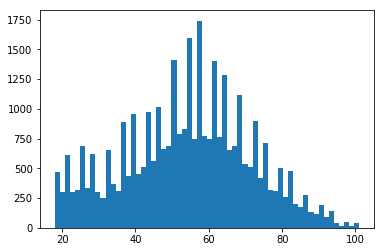

In [6]:
plt.hist(ml_import_data_sub.age, bins=60)
plt.show()

In [7]:
ml_import_data_sub = ml_import_data_sub.fillna(0)
data_informational = ml_import_data_sub[ml_import_data_sub.offer_type == 'informational']
data_bogo = ml_import_data_sub[ml_import_data_sub.offer_type == 'bogo']
data_discount = ml_import_data_sub[ml_import_data_sub.offer_type == 'discount']

print('informational data length: ', len(data_informational))
print('bogo data length: ', len(data_bogo))
print('discount data length: ', len(data_discount))

informational data length:  4865
bogo data length:  15116
discount data length:  13644


In [8]:
models = {}
for data, offer_type in zip([data_informational, data_discount, data_bogo], ['informational', 'discount', 'bogo']):
    X = data.drop(['person', 'offer_id', 'amount', 'offer_type'], axis=1)
    y = data['amount']
    models[offer_type] = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
    scores = cross_val_score(models[offer_type], X, y, cv=5)
    print(offer_type, scores)

informational [0.08947482 0.16810302 0.00505056 0.01920194 0.03815371]
discount [0.0975752  0.18490721 0.16364803 0.22520675 0.15613894]
bogo [0.17830011 0.19003371 0.14497853 0.17421256 0.20544693]


discount, bogoは多少改善の余地がありそうな気がするが、informationalは全然当たってない

予測値 vs 実測値 プロット

### bogo

In [9]:
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
X = data_bogo.drop(['person', 'offer_id', 'amount', 'offer_type'], axis=1)
y = data_bogo['amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model.fit(X_train, y_train)

print("training score: {}".format(model.score(X_train, y_train)))
print("test score: {}".format(model.score(X_test, y_test)))

training score: 0.31421271242997284
test score: 0.1889091464441117


学習不足であり、過学習もしてそう

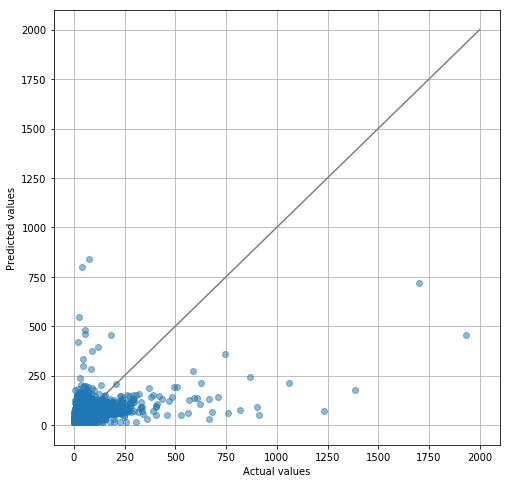

In [10]:
y_pred = model.predict(X_test)

plt.figure(figsize=(8, 8))

plt.plot((0, 2000), (0, 2000), color='gray')
plt.plot(y_test, y_pred, linewidth=0, marker='o', alpha=0.5)
plt.grid()
#plt.xlim((-0.2, 4.2))
#plt.ylim((-0.2, 4.2))
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

とりあえず、ターゲットの対数変換は試しておいた方が良さそう

In [11]:
data_bogo['amount_log'] = np.log(data_bogo.amount)

In [12]:
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
X = data_bogo.drop(['person', 'offer_id', 'amount', 'offer_type', 'amount_log'], axis=1)
y = data_bogo['amount_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model.fit(X_train, y_train)

print("training score: {}".format(model.score(X_train, y_train)))
print("test score: {}".format(model.score(X_test, y_test)))

training score: 0.5006951984659469
test score: 0.4642902225490302


結構スコアが上がる

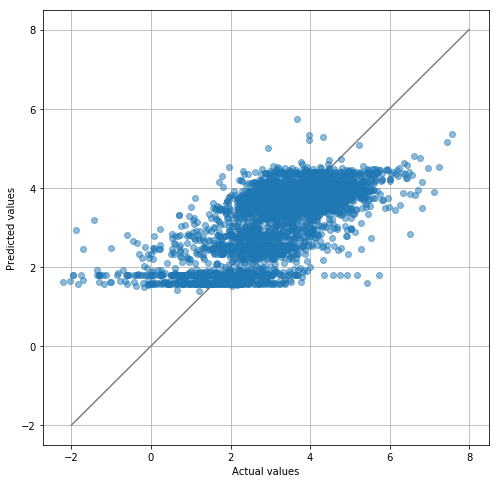

In [13]:
y_pred = model.predict(X_test)

plt.figure(figsize=(8, 8))

plt.plot((-2, 8), (-2, 8), color='gray')
plt.plot(y_test, y_pred, linewidth=0, marker='o', alpha=0.5)
plt.grid()
#plt.xlim((-0.2, 4.2))
#plt.ylim((-0.2, 4.2))
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

どちらにもぶれていて、同じ予測値を返している部分がある

In [14]:
importance_df = pd.DataFrame({'name':X.columns, 'importance': model.feature_importances_})
importance_df.sort_values(by='importance', ascending=False)

,name,importance
13,amount_mean,0.609260
12,amount_sum,0.150257
16,amount_median,0.081710
1,income,0.040363
25,registar_year_2018,0.038178
11,amount_max,0.022188
24,registar_year_2017,0.019540
10,amount_min,0.013543
14,amount_count,0.009866
15,amount_std,0.003266


median結構効果的

他の対数変換できそうな特徴量も対数変換してみる

In [15]:
data_bogo.columns

Index(['person', 'offer_id', 'amount', 'age', 'income', 'difficulty',
       'duration', 'offer_type', 'reward', 'num_channel', 'channel_web',
       'channel_email', 'channel_mobile', 'channel_social', 'amount_min',
       'amount_max', 'amount_sum', 'amount_mean', 'amount_count', 'amount_std',
       'amount_median', 'gender_F', 'gender_M', 'gender_O',
       'registar_year_2013', 'registar_year_2014', 'registar_year_2015',
       'registar_year_2016', 'registar_year_2017', 'registar_year_2018',
       'registar_month_1', 'registar_month_2', 'registar_month_3',
       'registar_month_4', 'registar_month_5', 'registar_month_6',
       'registar_month_7', 'registar_month_8', 'registar_month_9',
       'registar_month_10', 'registar_month_11', 'registar_month_12',
       'amount_log'],
      dtype='object')

In [16]:
log_cols = ['amount_min', 'income', 'amount_max', 'amount_sum', 'amount_mean', 'amount_median', 'amount_std']
for col in log_cols:
    col_name = col+'_log'
    data_bogo[col_name] = np.log(data_bogo[col] +1)

In [17]:
data_bogo.head()

,person,offer_id,amount,age,income,difficulty,duration,offer_type,reward,num_channel,...,registar_month_11,registar_month_12,amount_log,amount_min_log,income_log,amount_max_log,amount_sum_log,amount_mean_log,amount_median_log,amount_std_log
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,14.11,33,72000.0,5,5,bogo,5,4,...,0,0,2.646884,2.258633,11.184435,3.372798,4.531308,2.791983,2.655704,2.098175
6,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,54.04,40,57000.0,5,7,bogo,5,3,...,0,0,3.989725,2.673459,10.950824,2.673459,2.673459,2.673459,2.673459,0.000000
7,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17.24,59,90000.0,10,5,bogo,10,4,...,0,0,2.847232,2.903617,11.407576,3.551340,4.600459,3.243861,3.207410,2.161605
11,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.79,24,60000.0,5,7,bogo,5,3,...,1,0,2.878637,2.848971,11.002117,2.848971,2.848971,2.848971,2.848971,0.000000
12,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,54.30,24,60000.0,5,5,bogo,5,4,...,1,0,3.994524,2.848971,11.002117,2.848971,2.848971,2.848971,2.848971,0.000000


In [18]:
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
X = data_bogo.drop([
    'person', 
    'offer_id', 
    'amount', 
    'offer_type', 
    'amount_log',
    'amount_min', 
    'income', 
    'amount_max', 
    'amount_sum', 
    'amount_mean', 
    'amount_median', 
    'amount_std'
], axis=1)

y = data_bogo['amount_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model.fit(X_train, y_train)

print("training score: {}".format(model.score(X_train, y_train)))
print("test score: {}".format(model.score(X_test, y_test)))

training score: 0.5007332399846864
test score: 0.46410324426112237


そんなに意味ない

いくつか思いつくものを作る

In [19]:
data_bogo.head()

,person,offer_id,amount,age,income,difficulty,duration,offer_type,reward,num_channel,...,registar_month_11,registar_month_12,amount_log,amount_min_log,income_log,amount_max_log,amount_sum_log,amount_mean_log,amount_median_log,amount_std_log
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,14.11,33,72000.0,5,5,bogo,5,4,...,0,0,2.646884,2.258633,11.184435,3.372798,4.531308,2.791983,2.655704,2.098175
6,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,54.04,40,57000.0,5,7,bogo,5,3,...,0,0,3.989725,2.673459,10.950824,2.673459,2.673459,2.673459,2.673459,0.000000
7,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17.24,59,90000.0,10,5,bogo,10,4,...,0,0,2.847232,2.903617,11.407576,3.551340,4.600459,3.243861,3.207410,2.161605
11,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.79,24,60000.0,5,7,bogo,5,3,...,1,0,2.878637,2.848971,11.002117,2.848971,2.848971,2.848971,2.848971,0.000000
12,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,54.30,24,60000.0,5,5,bogo,5,4,...,1,0,3.994524,2.848971,11.002117,2.848971,2.848971,2.848971,2.848971,0.000000


In [20]:
data_bogo.columns

Index(['person', 'offer_id', 'amount', 'age', 'income', 'difficulty',
       'duration', 'offer_type', 'reward', 'num_channel', 'channel_web',
       'channel_email', 'channel_mobile', 'channel_social', 'amount_min',
       'amount_max', 'amount_sum', 'amount_mean', 'amount_count', 'amount_std',
       'amount_median', 'gender_F', 'gender_M', 'gender_O',
       'registar_year_2013', 'registar_year_2014', 'registar_year_2015',
       'registar_year_2016', 'registar_year_2017', 'registar_year_2018',
       'registar_month_1', 'registar_month_2', 'registar_month_3',
       'registar_month_4', 'registar_month_5', 'registar_month_6',
       'registar_month_7', 'registar_month_8', 'registar_month_9',
       'registar_month_10', 'registar_month_11', 'registar_month_12',
       'amount_log', 'amount_min_log', 'income_log', 'amount_max_log',
       'amount_sum_log', 'amount_mean_log', 'amount_median_log',
       'amount_std_log'],
      dtype='object')

In [21]:
data_bogo['scaled_difficulty'] = data_bogo.difficulty / data_bogo.duration
data_bogo['age_group'] = np.floor(data_bogo.age/10) *10
data_bogo['buy_rate'] = data_bogo.amount_sum / data_bogo.income
data_bogo['reward_inpact'] = data_bogo.reward / data_bogo.income
data_bogo['income_growth_potential'] = data_bogo.income / data_bogo.age

In [22]:
model = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=0)
X = data_bogo.drop([
    'person', 
    'offer_id', 
    'amount', 
    'offer_type', 
    'amount_log',
    'amount_min', 
    'income', 
    'amount_max', 
    'amount_sum', 
    'amount_mean', 
    'amount_median', 
    'amount_std'
], axis=1)

y = data_bogo['amount_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model.fit(X_train, y_train)

print("training score: {}".format(model.score(X_train, y_train)))
print("test score: {}".format(model.score(X_test, y_test)))

training score: 0.5240167085732748
test score: 0.4710406025138765


In [23]:
model = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=0)
X = data_bogo.drop([
    'person', 
    'offer_id', 
    'amount', 
    'offer_type', 
    'amount_log',
    'amount_min', 
    'income', 
    'amount_max', 
    'amount_sum', 
    'amount_mean', 
    'amount_median', 
    'amount_std'
], axis=1)

y = data_bogo['amount_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)
model.fit(X_train, y_train)

print("training score: {}".format(model.score(X_train, y_train)))
print("test score: {}".format(model.score(X_test, y_test)))

training score: 0.5741835255113787
test score: 0.48349104573898677


微妙にスコア上がったw

In [24]:
importance_df = pd.DataFrame({'name':X.columns, 'importance': model.feature_importances_})
importance_df.sort_values(by='importance', ascending=False)

,name,importance
35,amount_mean_log,0.546903
34,amount_sum_log,0.105700
36,amount_median_log,0.060022
40,buy_rate,0.048545
32,income_log,0.047947
18,registar_year_2018,0.032768
17,registar_year_2017,0.021037
33,amount_max_log,0.020979
31,amount_min_log,0.017654
42,income_growth_potential,0.014842


普段からどのくらいの購入能力があるのかに依存している気がする

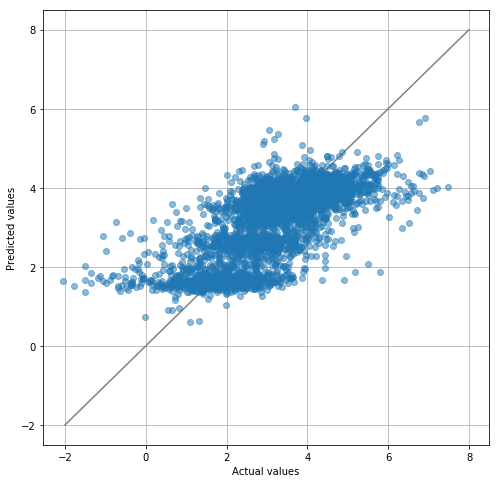

In [25]:
y_pred = model.predict(X_test)

plt.figure(figsize=(8, 8))

plt.plot((-2, 8), (-2, 8), color='gray')
plt.plot(y_test, y_pred, linewidth=0, marker='o', alpha=0.5)
plt.grid()
#plt.xlim((-0.2, 4.2))
#plt.ylim((-0.2, 4.2))
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

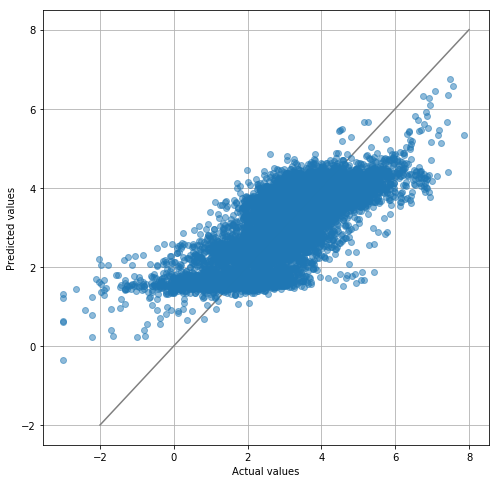

In [26]:
y_train_pred = model.predict(X_train)

plt.figure(figsize=(8, 8))

plt.plot((-2, 8), (-2, 8), color='gray')
plt.plot(y_train, y_train_pred, linewidth=0, marker='o', alpha=0.5)
plt.grid()
#plt.xlim((-0.2, 4.2))
#plt.ylim((-0.2, 4.2))
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

一定だった予測値がばらけ出した。良い感じ

これって、Predicted valueをさらに特徴量にしてActual valueを回帰するみたいなのやって良いのか？

やったら精度めっちゃ改善しそう（これのこと、スタッキングと呼ぶのか？）

### TODO:
特徴量作成のコードに足したものを足す。
スタッキング試してみる